In [1]:
import numpy as np
import gzip
import os
import requests
import datetime
from numpy.typing import NDArray
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
# define the network architecture and helper functions so we can load the weights into a model instance
def fetch_mnist_data() -> Tuple[Tuple[NDArray[np.uint8], NDArray[np.uint8]], Tuple[NDArray[np.uint8], NDArray[np.uint8]]]:
    """
    Downloads and loads the MNIST dataset into numpy arrays.
    The data is downloaded from Yann LeCun's website and saved locally.
    """

    # URLs for the MNIST dataset files
    urls = {
        'train_images': 'https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz',
        'train_labels': 'https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz',
        'test_images': 'https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz',
        'test_labels': 'https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz'
    }

    data_dir = 'mnist_data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Download and verify files
    for key, url in urls.items():
        filepath = os.path.join(data_dir, os.path.basename(url))
        if not os.path.exists(filepath):
            print(f"Downloading {url}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

    # Function to parse the IDX files
    def parse_idx_file(file_path: str, is_images: bool=True):
        with gzip.open(file_path, 'rb') as f:
            if is_images:
                # Skip the magic number (4 bytes) and number of images (4 bytes)
                # Read number of rows (4 bytes) and columns (4 bytes)
                f.read(8)
                rows = int.from_bytes(f.read(4), 'big')
                cols = int.from_bytes(f.read(4), 'big')
                buf = f.read()
                data = np.frombuffer(buf, dtype=np.uint8).reshape(-1, rows, cols)
            else:
                # Skip magic number (4 bytes) and number of items (4 bytes)
                f.read(8)
                buf = f.read()
                data = np.frombuffer(buf, dtype=np.uint8)
        return data

    X_train = parse_idx_file(os.path.join(data_dir, 'train-images-idx3-ubyte.gz'), is_images=True)
    y_train = parse_idx_file(os.path.join(data_dir, 'train-labels-idx1-ubyte.gz'), is_images=False)
    X_test = parse_idx_file(os.path.join(data_dir, 't10k-images-idx3-ubyte.gz'), is_images=True)
    y_test = parse_idx_file(os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz'), is_images=False)

    return (X_train, y_train), (X_test, y_test)

def preprocess_data(X: NDArray[np.uint8], y: NDArray[np.uint8]) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    """
    Preprocesses the MNIST data for the MLP.
    - Flattens the 28x28 images into 784-element vectors.
    - Normalizes pixel values from [0, 255] to [0, 1].
    - One-hot encodes the labels.
    """
    # Flatten images
    X_flattened = X.reshape(X.shape[0], -1).astype('float32')

    # Normalize pixel values
    X_normalized = X_flattened / 255.0

    # One-hot encode labels
    y_one_hot = np.zeros((y.size, y.max() + 1))
    y_one_hot[np.arange(y.size), y] = 1

    return X_normalized.T, y_one_hot.T # Transpose for easier matrix math (features x examples)

In [3]:
# Model definitions and functions

def relu(Z: NDArray[np.float32]) -> NDArray[np.float32]:
    return np.maximum(0, Z)

def relu_derivative(Z: NDArray[np.float32]) -> NDArray[np.bool_]:
    """Derivative of the ReLU function."""
    return Z > 0

def softmax(Z: NDArray[np.float32]) -> NDArray[np.float32]:
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

class SimpleMLP:
    """A simple Multi-Layer Perceptron for classification."""
    W1: NDArray[np.float32]
    b1: NDArray[np.float32]
    W2: NDArray[np.float32]
    b2: NDArray[np.float32]

    def __init__(self, input_size, hidden_size, output_size):
        """
        Initializes the network's weights and biases.
        - W1, b1: Weights and bias for the hidden layer.
        - W2, b2: Weights and bias for the output layer.
        """
        # He initialization for weights is often better for ReLU
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((output_size, 1))

    def forward_pass(self, X: NDArray[np.float32]) -> Tuple[NDArray[np.float32], Dict[str, NDArray[np.float32]]]:
        """
        Performs the forward pass through the network.
        X -> [LINEAR -> RELU] -> [LINEAR -> SOFTMAX] -> A2
        Returns the final activation (A2) and a cache of intermediate values for backprop.
        """
        # Layer 1 (Hidden)
        Z1 = self.W1.dot(X) + self.b1
        A1 = relu(Z1)

        # Layer 2 (Output)
        Z2 = self.W2.dot(A1) + self.b2
        A2 = softmax(Z2)

        # Cache values needed for the backward pass
        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
        return A2, cache

    def backward_pass(self, X: NDArray[np.float32], Y: NDArray[np.float32], cache: Dict[str, NDArray[np.float32]]) -> Dict[str, NDArray[np.float32]]:
        """
        Performs the backward pass (backpropagation) to compute gradients.
        Y: The true labels (one-hot encoded).
        """
        m = X.shape[1] # Number of examples in the batch
        A1 = cache['A1']
        A2 = cache['A2']

        # --- Gradient calculation for the output layer (W2, b2) ---
        # The derivative of Cross-Entropy Loss with Softmax is simply (A2 - Y)
        dZ2 = A2 - Y
        dW2 = (1 / m) * dZ2.dot(A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

        # --- Gradient calculation for the hidden layer (W1, b1) ---
        # Propagate the error back
        dZ1 = self.W2.T.dot(dZ2) * relu_derivative(cache['Z1'])
        dW1 = (1 / m) * dZ1.dot(X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return gradients

    def update_parameters(self, gradients, learning_rate):
        """
        Updates the network's parameters using gradient descent.
        """
        self.W1 -= learning_rate * gradients['dW1']
        self.b1 -= learning_rate * gradients['db1']
        self.W2 -= learning_rate * gradients['dW2']
        self.b2 -= learning_rate * gradients['db2']

class ConfigurableMLP:
    """A Multi-Layer Perceptron with a configurable number of layers."""

    def __init__(self, layer_dims: List[int]):
        """
        Initializes the network's parameters.
        
        Args:
            layer_dims: A list of integers specifying the number of neurons in each
                        layer, starting with the input layer.
                        Example: [784, 128, 64, 10]
        """
        self.params: Dict[str, NDArray[np.float32]] = {}
        self.num_layers = len(layer_dims)

        for layer in range(1, self.num_layers):
            # He initialization is good for ReLU layers
            self.params[f'W{layer}'] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * np.sqrt(2. / layer_dims[layer-1])
            self.params[f'b{layer}'] = np.zeros((layer_dims[layer], 1))

    # def forward_pass(self, X: np.ndarray) -> Tuple[np.ndarray, List[Any]]:
    def forward_pass(self, X: NDArray[np.float32]) -> Tuple[NDArray[np.float32], Dict[str, NDArray[np.float32]]]:
        """
        Performs the forward pass through all layers of the network.
        """
        caches = []
        A = X
        
        # Loop through hidden layers (ReLU activation)
        for layer in range(1, self.num_layers - 1):
            A_prev = A
            W = self.params[f'W{layer}']
            b = self.params[f'b{layer}']
            
            Z = W.dot(A_prev) + b
            A = relu(Z)
            
            cache = {"A_prev": A_prev, "Z": Z}
            caches.append(cache)
            
        # Handle the output layer (Softmax activation)
        A_prev = A
        W_last = self.params[f'W{self.num_layers - 1}']
        b_last = self.params[f'b{self.num_layers - 1}']
        
        Z_last = W_last.dot(A_prev) + b_last
        A_last = softmax(Z_last)
        
        cache = {"A_prev": A_prev, "Z": Z_last}
        caches.append(cache)
        
        return A_last, caches

    def backward_pass(self, AL: NDArray[np.float32], Y: NDArray[np.float32], caches: List[Dict[str, NDArray[np.float32]]]) -> Dict[str, NDArray[np.float32]]:
        """
        Performs backpropagation to compute gradients for all layers.
        """
        grads: Dict[str, NDArray[np.float32]] = {}
        m = Y.shape[1]
        
        # --- Gradient for the output layer ---
        # The derivative of Cross-Entropy Loss with Softmax is simple
        dZ = AL - Y
        
        last_cache = caches[self.num_layers - 2]
        A_prev = last_cache['A_prev']
        
        grads[f'dW{self.num_layers - 1}'] = (1 / m) * dZ.dot(A_prev.T)
        grads[f'db{self.num_layers - 1}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = self.params[f'W{self.num_layers - 1}'].T.dot(dZ)
        
        # --- Loop backwards through the hidden layers ---
        for layer in reversed(range(1, self.num_layers - 1)):
            cache = caches[layer-1]
            Z = cache['A_prev']
            
            # Gradient for ReLU layer
            dZ = dA_prev * relu_derivative(cache['Z'])
            
            A_prev = cache['A_prev']
            grads[f'dW{layer}'] = (1 / m) * dZ.dot(A_prev.T)
            grads[f'db{layer}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = self.params[f'W{layer}'].T.dot(dZ)
            
        return grads

    def update_parameters(self, grads: Dict[str, NDArray[np.float32]], learning_rate: float):
        """
        Updates the network's parameters using gradient descent.
        """
        for layer in range(1, self.num_layers):
            self.params[f'W{layer}'] -= learning_rate * grads[f'dW{layer}']
            self.params[f'b{layer}'] -= learning_rate * grads[f'db{layer}']

In [4]:
# Functions / Classes for plots
class TrainingHistory:
    def __init__(self, train_loss: List[float], train_accuracy: List[float], validation_loss: List[float], validation_accuracy: List[float]):
        self.train_loss = train_loss
        self.train_accuracy = train_accuracy
        self.validation_loss = validation_loss
        self.validation_accuracy = validation_accuracy

def plot_training_history(history: TrainingHistory, text: str = ""):
    """Plots the training and validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    if text:
        fig.suptitle(text, fontsize=14)
    
    # Plot Loss
    ax1.plot(history.train_loss, label='Training Loss', color='blue')
    ax1.plot(history.validation_loss, label='Validation Loss', color='orange')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot Accuracy
    ax2.plot(history.train_accuracy, label='Training Accuracy', color='blue')
    ax2.plot(history.validation_accuracy, label='Validation Accuracy', color='orange')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_misclassified_images(
    X_test_orig: NDArray[np.float32],
    y_test_orig: NDArray[np.float32],
    y_pred: NDArray[np.float32],
    num_images: int = 25
):
    """
    Plots a grid of images that the model misclassified.
    """
    # Find the indices of all misclassified images
    misclassified_indices = np.where(y_pred != y_test_orig)[0]
    
    if len(misclassified_indices) == 0:
        print("Congratulations! No images were misclassified.")
        return
        
    print(f"Found {len(misclassified_indices)} misclassified images.")
    
    # Randomly select a subset of the misclassified images to display
    random_indices = np.random.choice(misclassified_indices, min(num_images, len(misclassified_indices)), replace=False)
    
    rows = int(np.ceil(np.sqrt(len(random_indices))))
    cols = int(np.ceil(len(random_indices) / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 1.7 * rows))
    axes = axes.flatten() # Flatten to make it easy to iterate
    
    for i, ax in enumerate(axes):
        if i < len(random_indices):
            idx = random_indices[i]
            ax.imshow(X_test_orig[idx], cmap='gray')
            ax.set_title(f"True: {y_test_orig[idx]}\nPred: {y_pred[idx]}")
            ax.axis('off')
        else:
            # Hide unused subplots
            ax.axis('off')
            
    plt.tight_layout()
    plt.suptitle("Misclassified Image Examples", fontsize=16, y=1.02)
    plt.show()

In [5]:
# Functions to train the model
def get_predictions(A2: NDArray[np.float32]) -> NDArray[np.int_]:
    """Gets the class predictions from the output activations."""
    return np.argmax(A2, axis=0)

def get_accuracy(predictions: NDArray[np.int_], Y: NDArray[np.float32]) -> float:
    """Calculates the accuracy of the predictions."""
    # Y is one-hot, so we get the true class index with argmax
    true_labels = np.argmax(Y, axis=0)
    return np.sum(predictions == true_labels) / Y.shape[1]

def calculate_loss(
    AL: NDArray[np.float32],
    Y: NDArray[np.float32],
    params: Dict[str, NDArray[np.float32]],
    regularization_strength: float
) -> float:
    """Calculates categorical cross-entropy loss with L2 regularization."""
    m = Y.shape[1]
    num_layers = len(params) // 2

    # Standard cross-entropy loss
    cross_entropy_cost = -np.sum(Y * np.log(AL + 1e-8)) / m

    # L2 regularization cost
    l2_regularization_cost = 0
    for l in range(1, num_layers + 1):
        l2_regularization_cost += np.sum(np.square(params[f'W{l}']))

    l2_regularization_cost = (regularization_strength / (2 * m)) * l2_regularization_cost

    # Total loss
    total_loss = cross_entropy_cost + l2_regularization_cost
    return total_loss

def train(
        X_train: NDArray[np.float32],
        Y_train: NDArray[np.float32],
        X_test: NDArray[np.float32],
        Y_test: NDArray[np.float32],
        epochs: int,
        learning_rate: float,
        batch_size: int,
        hidden_size: int
    ) -> Tuple[SimpleMLP, TrainingHistory]:
    """
    The main training loop for the neural network.
    """
    input_size = X_train.shape[0]
    output_size = Y_train.shape[0]
    num_samples = X_train.shape[1]

    training_history = TrainingHistory([], [], [], [])
    model = SimpleMLP(input_size, hidden_size, output_size)

    for i in range(epochs):
        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[:, permutation]
        Y_shuffled = Y_train[:, permutation]

        for j in range(0, num_samples, batch_size):
            # Get mini-batch
            end = j + batch_size
            X_batch = X_shuffled[:, j:end]
            Y_batch = Y_shuffled[:, j:end]

            # 1. Forward pass
            A2, cache = model.forward_pass(X_batch)

            # 2. Backward pass
            gradients = model.backward_pass(X_batch, Y_batch, cache)

            # 3. Update parameters
            model.update_parameters(gradients, learning_rate)

        # Print progress after each epoch
        # Use the full training set for this calculation
        A2_full_train, _ = model.forward_pass(X_train)
        predictions_train = get_predictions(A2_full_train)
        accuracy_train = get_accuracy(predictions_train, Y_train)

        # Calculate loss (Categorical Cross-Entropy)
        loss_train = -np.sum(Y_train * np.log(A2_full_train + 1e-8)) / Y_train.shape[1] # add small epsilon for stability

        training_history.train_accuracy.append(accuracy_train)
        training_history.train_loss.append(loss_train)

        print(f"Epoch {i+1}/{epochs} - Loss: {loss_train:.4f} - Accuracy: {accuracy_train:.4f}")

        # validation metrics
        A2_full_test, _ = model.forward_pass(X_test)
        predictions_test = get_predictions(A2_full_test)
        accuracy_test = get_accuracy(predictions_test, Y_test)

        # Calculate loss (Categorical Cross-Entropy)
        loss_test = -np.sum(Y_test * np.log(A2_full_test + 1e-8)) / Y_test.shape[1] # add small epsilon for stability
        training_history.validation_accuracy.append(accuracy_test)
        training_history.validation_loss.append(loss_test)

    return model, training_history

def train_configurable_mlp(
    X_train: NDArray[np.float32], 
    Y_train: NDArray[np.float32], 
    X_test: NDArray[np.float32], 
    Y_test: NDArray[np.float32], 
    layer_dimensions: List[int], 
    epochs: int, 
    learning_rate: float, 
    batch_size: int,
    regularization_strength: float = 0.0,
) -> Tuple[ConfigurableMLP, TrainingHistory]:
    """
    The main training loop for the configurable neural network.
    
    Args:
        X: Input data (features x number of examples).
        Y: True labels, one-hot encoded (classes x number of examples).
        layer_dims: A list defining the network architecture.
        epochs: Number of full passes through the training data.
        learning_rate: Step size for gradient descent.
        batch_size: Number of examples in each mini-batch.
        
    Returns:
        The trained model instance.
    """
    num_samples = X_train.shape[1]
    training_history = TrainingHistory([], [], [], [])

    # Initialize the model based on the provided architecture
    model = ConfigurableMLP(layer_dimensions)
    
    print(f"Starting training for model with architecture: layer_dimensions={layer_dimensions}, regularization_strength={regularization_strength}")
    
    for i in range(epochs):
        # Shuffle the data for each epoch to ensure random batches
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[:, permutation]
        Y_shuffled = Y_train[:, permutation]

        for j in range(0, num_samples, batch_size):
            # Get mini-batch
            end = j + batch_size
            X_batch = X_shuffled[:, j:end]
            Y_batch = Y_shuffled[:, j:end]

            # 1. Forward pass
            AL, caches = model.forward_pass(X_batch)
            
            # 2. Backward pass
            gradients = model.backward_pass(AL, Y_batch, caches)
            
            # 3. Update parameters
            model.update_parameters(gradients, learning_rate)
        
        # --- Logging after each epoch ---
        # Use the full training set for logging accuracy and loss
        AL_full_train, _ = model.forward_pass(X_train)
        predictions_train = get_predictions(AL_full_train)
        accuracy_train = get_accuracy(predictions_train, Y_train)
        
        # Calculate loss (Categorical Cross-Entropy)
        # loss_train = -np.sum(Y_train * np.log(AL_full_train + 1e-8)) / Y_train.shape[1]
        loss_train = calculate_loss(AL_full_train, Y_train, model.params, regularization_strength)

        training_history.train_accuracy.append(accuracy_train)
        training_history.train_loss.append(loss_train)
        
        print(f"Epoch {i+1}/{epochs} - Loss: {loss_train:.4f} - Accuracy: {accuracy_train:.4f}")

        # validation metrics
        AL_full_test, _ = model.forward_pass(X_test)
        predictions_test = get_predictions(AL_full_test)
        accuracy_test = get_accuracy(predictions_test, Y_test)
        loss_test = calculate_loss(AL_full_test, Y_test, model.params, regularization_strength)
        training_history.validation_accuracy.append(accuracy_test)
        training_history.validation_loss.append(loss_test)
        
    return model, training_history


In [6]:
# Load and preprocess the test data
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fetch_mnist_data()
X_train, y_train = preprocess_data(X_train_orig, y_train_orig)
X_test, y_test = preprocess_data(X_test_orig, y_test_orig)
print("Test data loaded.")

Test data loaded.


In [7]:
# Training variables
EPOCHS = 40
LEARNING_RATE = 0.05
BATCH_SIZE = 128
HIDDEN_LAYER_SIZE = 512

# Train the model
print("\nStarting training...")
trained_model, training_history = train(
    X_train=X_train,
    Y_train=y_train,
    X_test=X_test,
    Y_test=y_test,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    hidden_size=HIDDEN_LAYER_SIZE
)
print("Training complete")

# Create the filename using the timestamp
# Note: It's often better to avoid spaces and colons in filenames
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
weights_file = f'./mlp_weights/mnist_mlp_weights_{timestamp}.npz'
print(f"Weights will be saved to: {weights_file}")

# After the training loop finishes
print("Saving model weights...")
np.savez(
    weights_file, 
    W1=trained_model.W1, 
    b1=trained_model.b1, 
    W2=trained_model.W2, 
    b2=trained_model.b2
)
print(f"Weights saved to {weights_file}")


Starting training...
Epoch 1/40 - Loss: 0.3326 - Accuracy: 0.9076
Epoch 2/40 - Loss: 0.2703 - Accuracy: 0.9236
Epoch 3/40 - Loss: 0.2307 - Accuracy: 0.9363
Epoch 4/40 - Loss: 0.2045 - Accuracy: 0.9433
Epoch 5/40 - Loss: 0.1837 - Accuracy: 0.9491
Epoch 6/40 - Loss: 0.1653 - Accuracy: 0.9544
Epoch 7/40 - Loss: 0.1525 - Accuracy: 0.9578
Epoch 8/40 - Loss: 0.1410 - Accuracy: 0.9611
Epoch 9/40 - Loss: 0.1312 - Accuracy: 0.9639
Epoch 10/40 - Loss: 0.1211 - Accuracy: 0.9667
Epoch 11/40 - Loss: 0.1132 - Accuracy: 0.9694
Epoch 12/40 - Loss: 0.1073 - Accuracy: 0.9707
Epoch 13/40 - Loss: 0.1011 - Accuracy: 0.9727
Epoch 14/40 - Loss: 0.0947 - Accuracy: 0.9747
Epoch 15/40 - Loss: 0.0908 - Accuracy: 0.9759
Epoch 16/40 - Loss: 0.0854 - Accuracy: 0.9779
Epoch 17/40 - Loss: 0.0812 - Accuracy: 0.9785
Epoch 18/40 - Loss: 0.0783 - Accuracy: 0.9796
Epoch 19/40 - Loss: 0.0742 - Accuracy: 0.9806
Epoch 20/40 - Loss: 0.0707 - Accuracy: 0.9819
Epoch 21/40 - Loss: 0.0679 - Accuracy: 0.9826
Epoch 22/40 - Loss: 0


Evaluating on the test set...
Test Accuracy: 0.9787
Found 213 misclassified images.


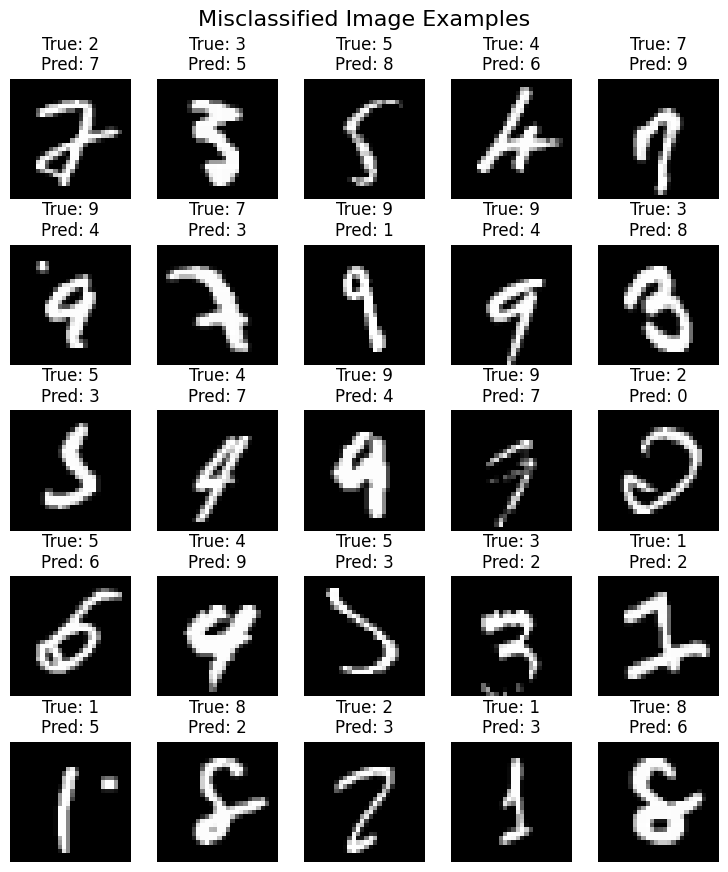

In [8]:
# Evaluate on the test set
print("\nEvaluating on the test set...")
A2_test, _ = trained_model.forward_pass(X_test)
predictions_test = get_predictions(A2_test)
test_accuracy = get_accuracy(predictions_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_misclassified_images(X_test_orig=X_test_orig, y_test_orig=y_test_orig, y_pred=predictions_test)

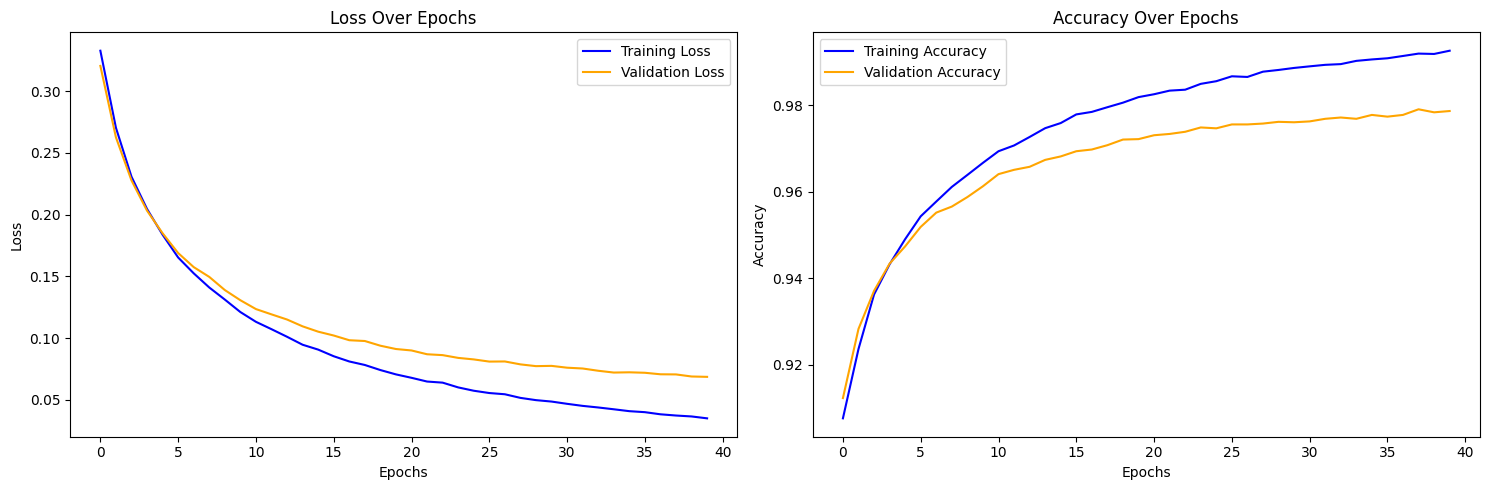

In [9]:
plot_training_history(training_history)

In [10]:
class MLPConfiguration:
    def __init__(self, layer_dimensions: List[int], epochs: int, learning_rate: float, batch_size: int, regularization_strength: float):
        self.layer_dimensions = layer_dimensions
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.regularization_strength = regularization_strength

    def __dict__(self):
        return {
            "layer_dimensions": self.layer_dimensions,
            "epochs": self.epochs,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "regularization_strength": self.regularization_strength,
        }

    def __str__(self):
        return str(self.__dict__())

mlp_configurations = [
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),
    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 1024, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),
]

In [11]:
configurable_mlp_results: List[Tuple[MLPConfiguration, ConfigurableMLP, TrainingHistory, float]] = []
for mlp_configuration in mlp_configurations:
    start = datetime.datetime.now()
    trained_configurable_model, configurable_model_training_history = train_configurable_mlp(
        X_train=X_train,
        Y_train=y_train,
        X_test=X_test,
        Y_test=y_test,
        layer_dimensions=mlp_configuration.layer_dimensions,
        epochs=mlp_configuration.epochs,
        learning_rate=mlp_configuration.learning_rate,
        batch_size=mlp_configuration.batch_size,
        regularization_strength=mlp_configuration.regularization_strength,
    )
    end = datetime.datetime.now()
    configurable_mlp_results.append((mlp_configuration, trained_configurable_model, configurable_model_training_history, (end - start).total_seconds()))

Starting training for model with architecture: layer_dimensions=[784, 10], regularization_strength=0.0
Epoch 1/20 - Loss: 0.4719 - Accuracy: 0.8783
Epoch 2/20 - Loss: 0.4014 - Accuracy: 0.8913
Epoch 3/20 - Loss: 0.3701 - Accuracy: 0.8978
Epoch 4/20 - Loss: 0.3518 - Accuracy: 0.9024
Epoch 5/20 - Loss: 0.3398 - Accuracy: 0.9052
Epoch 6/20 - Loss: 0.3309 - Accuracy: 0.9075
Epoch 7/20 - Loss: 0.3237 - Accuracy: 0.9093
Epoch 8/20 - Loss: 0.3177 - Accuracy: 0.9113
Epoch 9/20 - Loss: 0.3127 - Accuracy: 0.9134
Epoch 10/20 - Loss: 0.3086 - Accuracy: 0.9143
Epoch 11/20 - Loss: 0.3054 - Accuracy: 0.9149
Epoch 12/20 - Loss: 0.3021 - Accuracy: 0.9160
Epoch 13/20 - Loss: 0.3004 - Accuracy: 0.9160
Epoch 14/20 - Loss: 0.2973 - Accuracy: 0.9176
Epoch 15/20 - Loss: 0.2949 - Accuracy: 0.9183
Epoch 16/20 - Loss: 0.2935 - Accuracy: 0.9180
Epoch 17/20 - Loss: 0.2908 - Accuracy: 0.9190
Epoch 18/20 - Loss: 0.2893 - Accuracy: 0.9197
Epoch 19/20 - Loss: 0.2885 - Accuracy: 0.9196
Epoch 20/20 - Loss: 0.2872 - Acc


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 4.357809
Test Accuracy: 0.9209
Found 791 misclassified images.


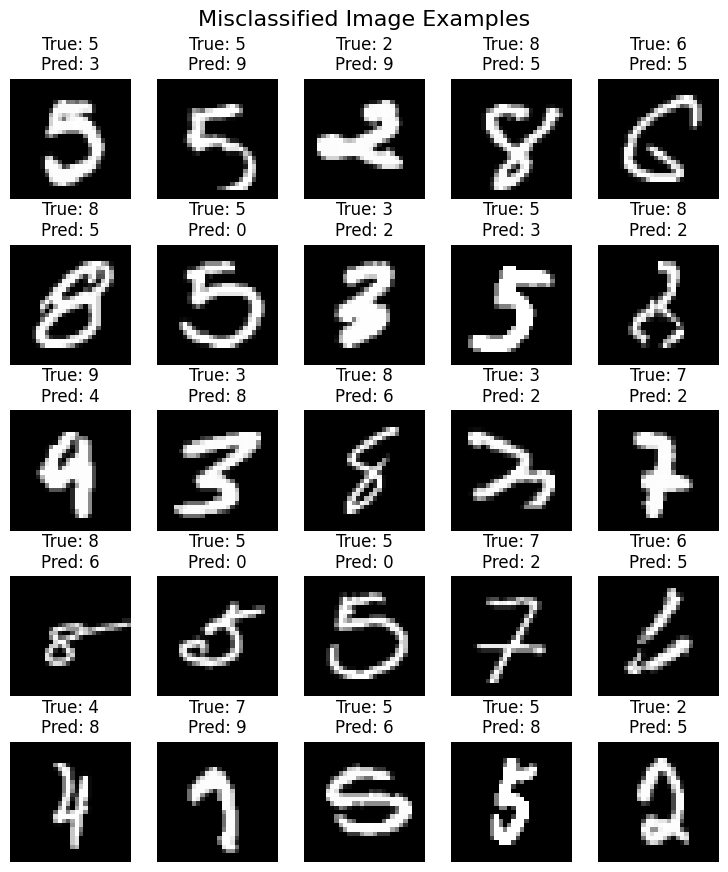


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 4.257333
Test Accuracy: 0.9200
Found 800 misclassified images.


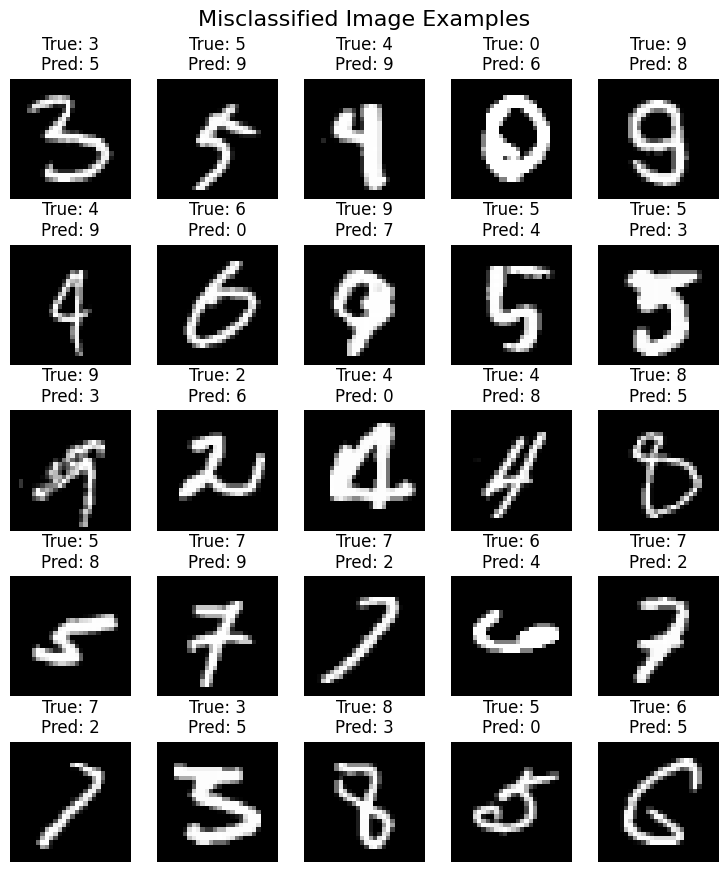


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 4.221368
Test Accuracy: 0.9206
Found 794 misclassified images.


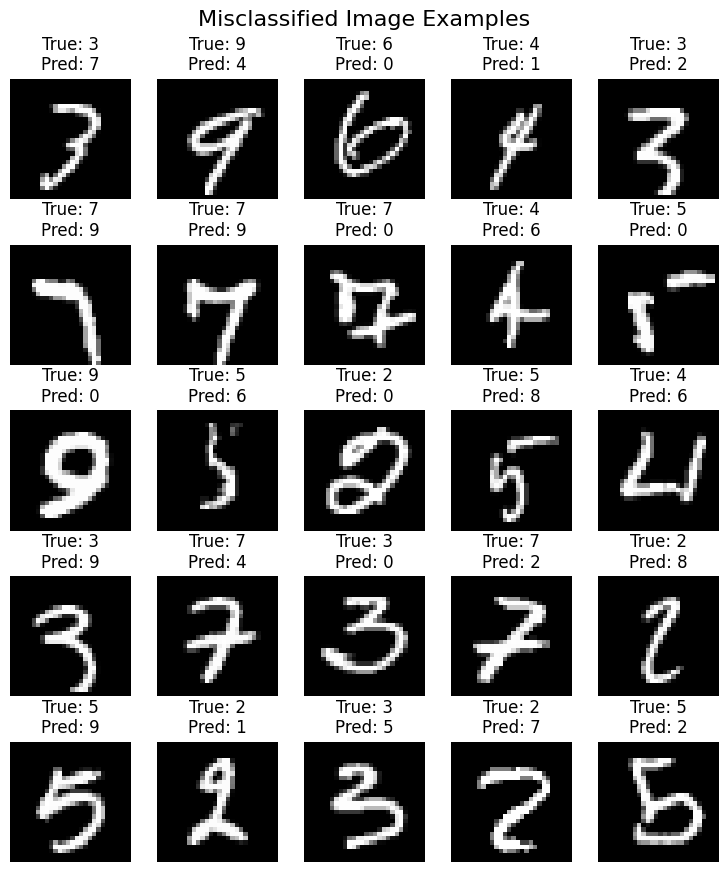


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 4.333106
Test Accuracy: 0.9207
Found 793 misclassified images.


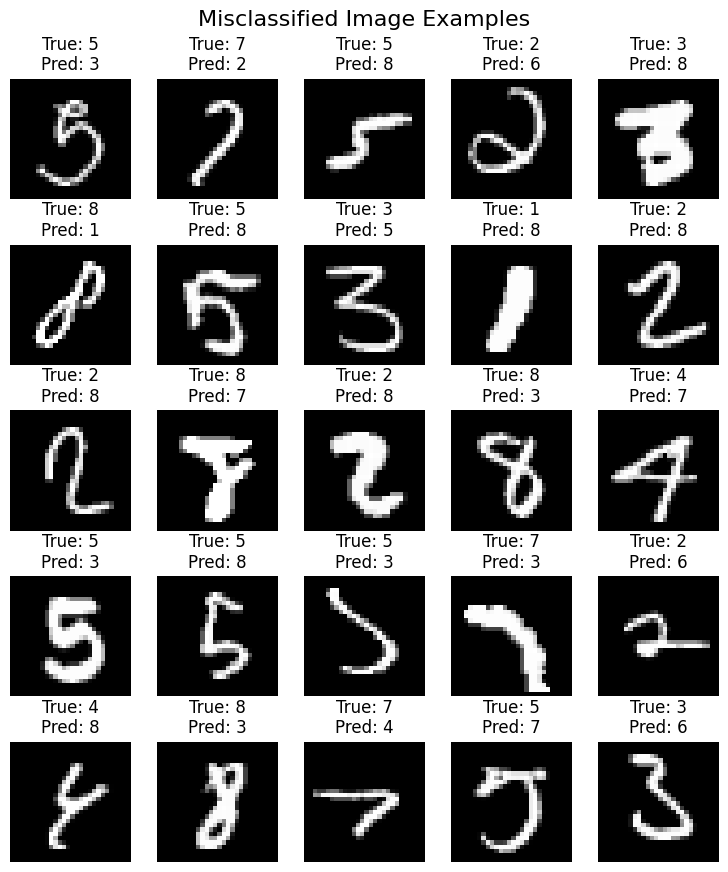


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 18.853456
Test Accuracy: 0.9731
Found 269 misclassified images.


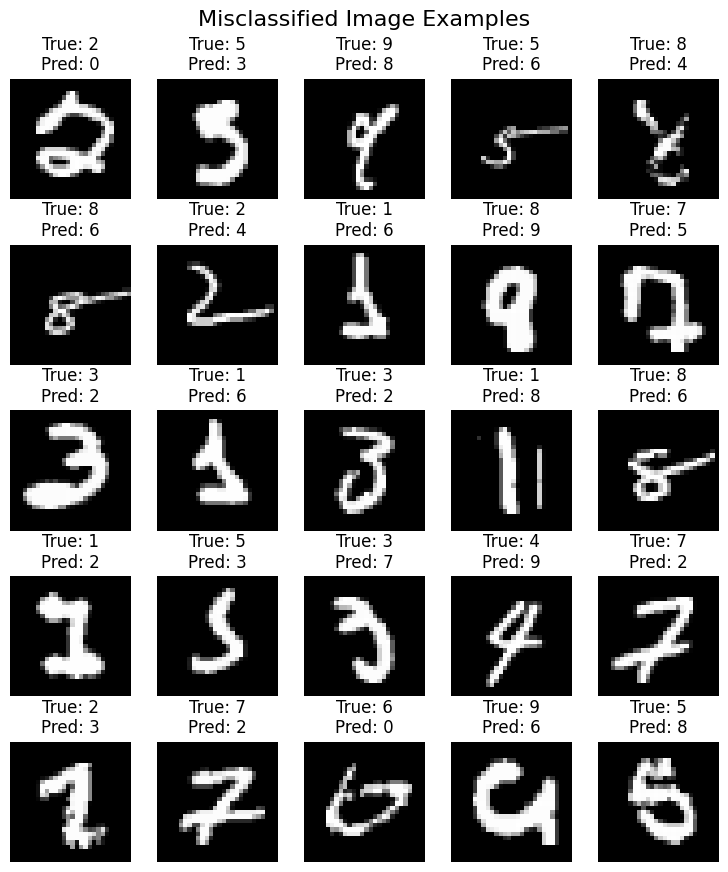


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 16.257117
Test Accuracy: 0.9727
Found 273 misclassified images.


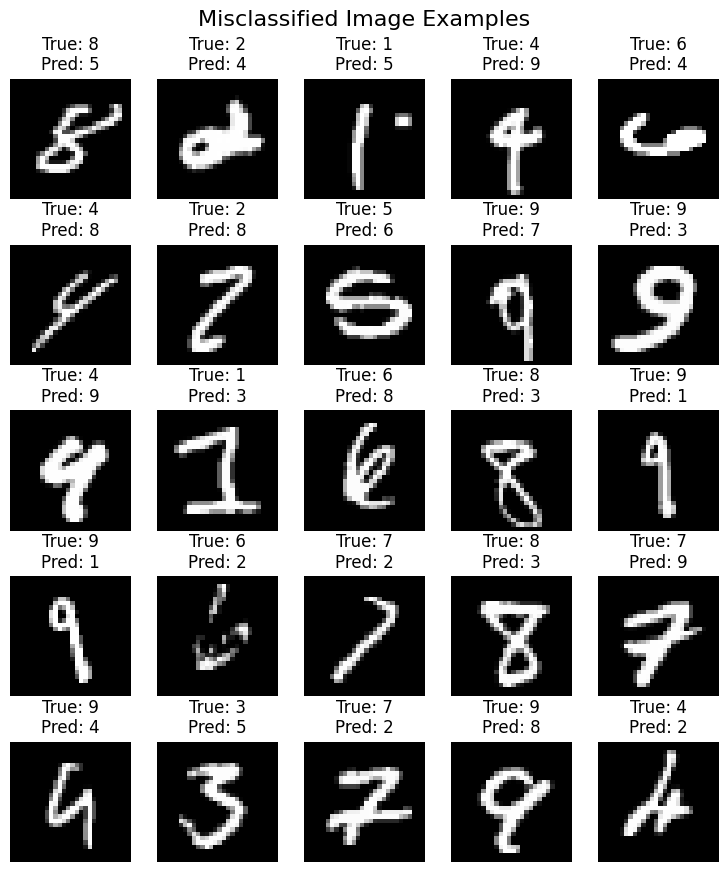


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 16.3851
Test Accuracy: 0.9709
Found 291 misclassified images.


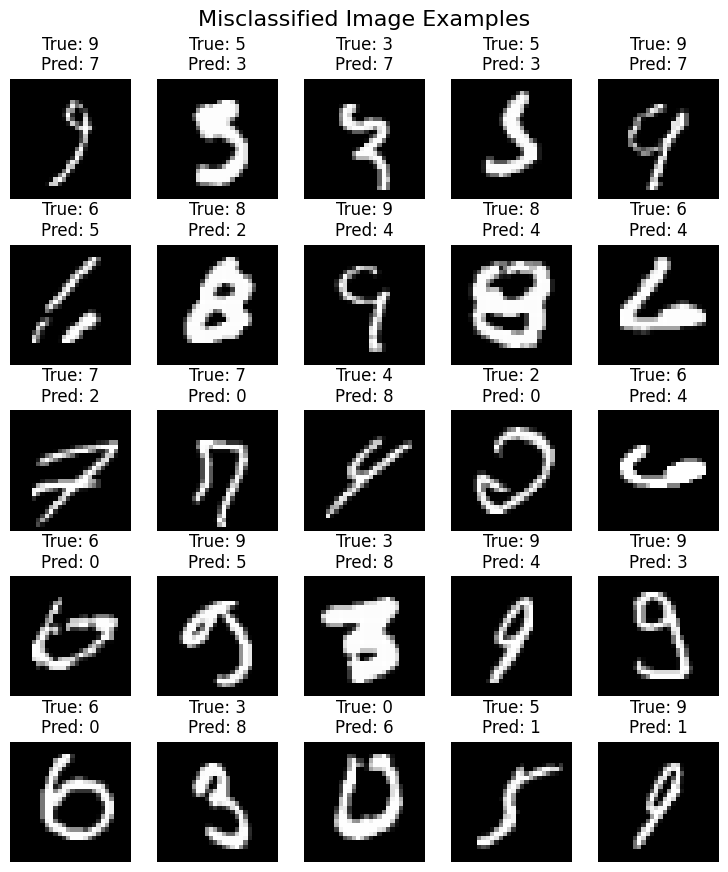


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 16.170892
Test Accuracy: 0.9734
Found 266 misclassified images.


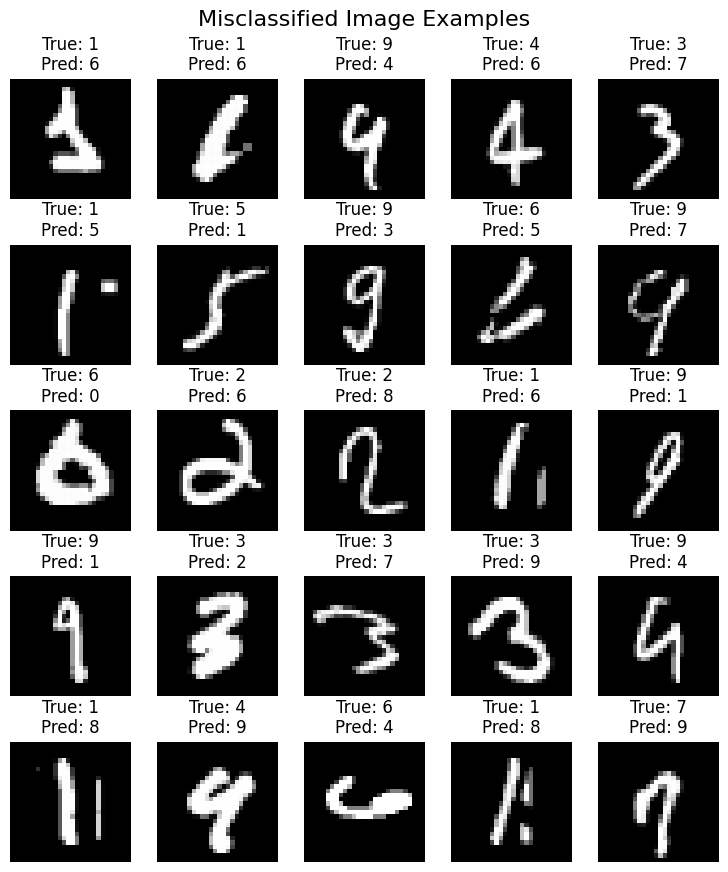


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 49.615438
Test Accuracy: 0.9788
Found 212 misclassified images.


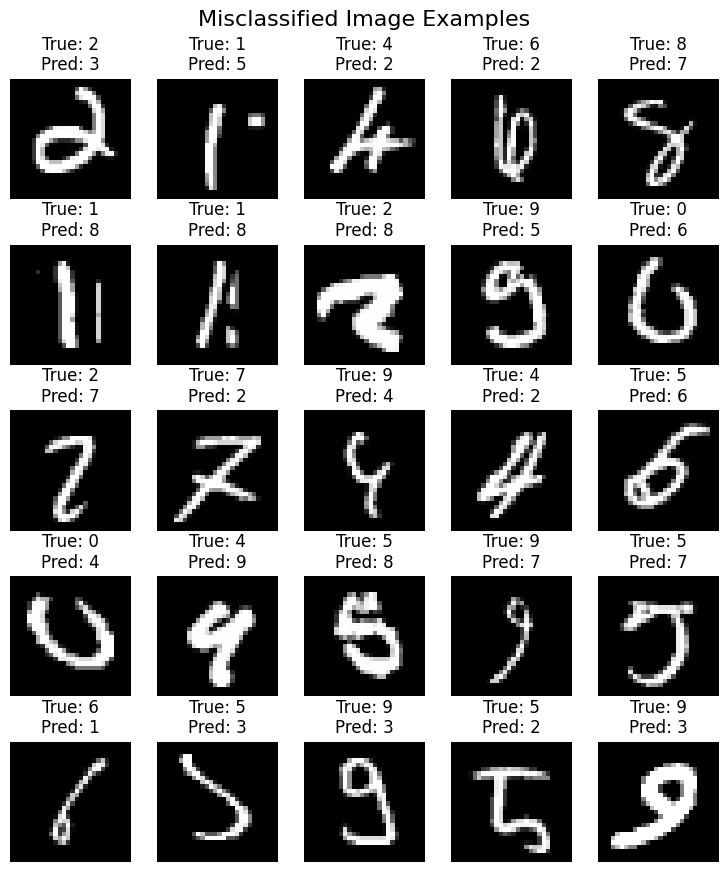


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 48.552996
Test Accuracy: 0.9800
Found 200 misclassified images.


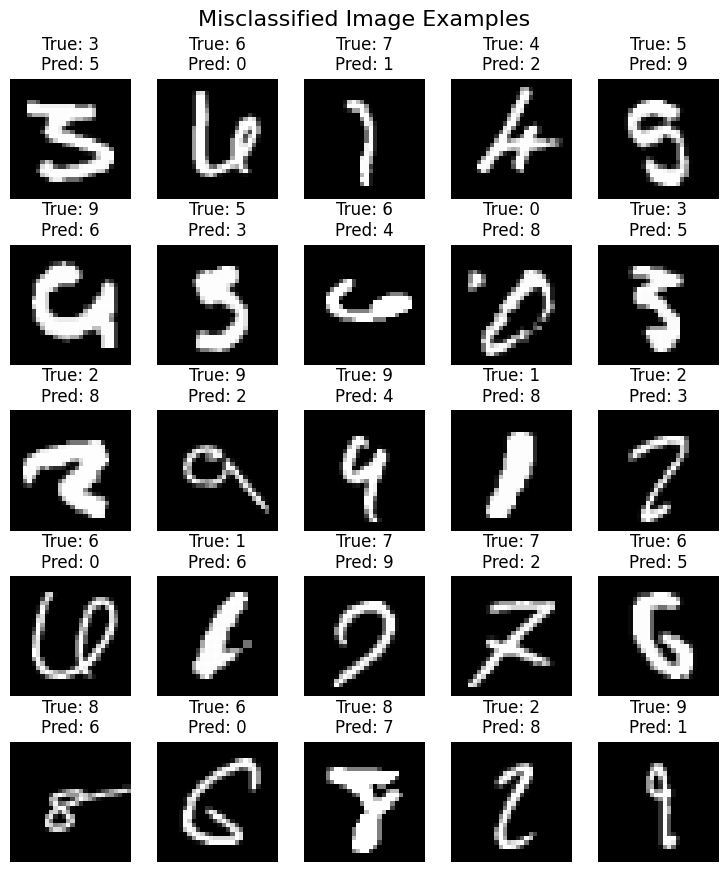


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 51.884147
Test Accuracy: 0.9790
Found 210 misclassified images.


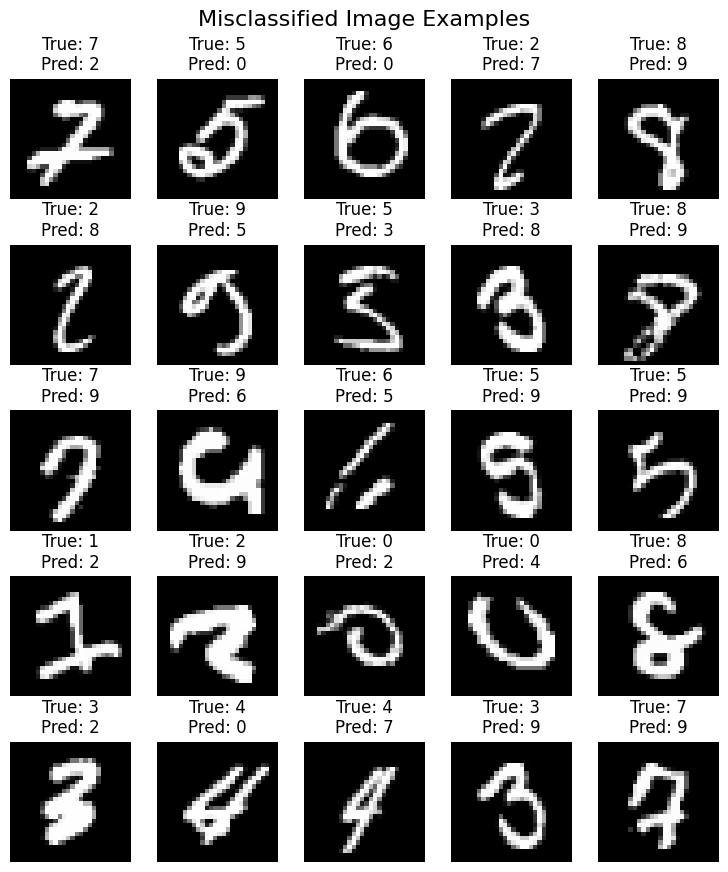


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 51.806779
Test Accuracy: 0.9726
Found 274 misclassified images.


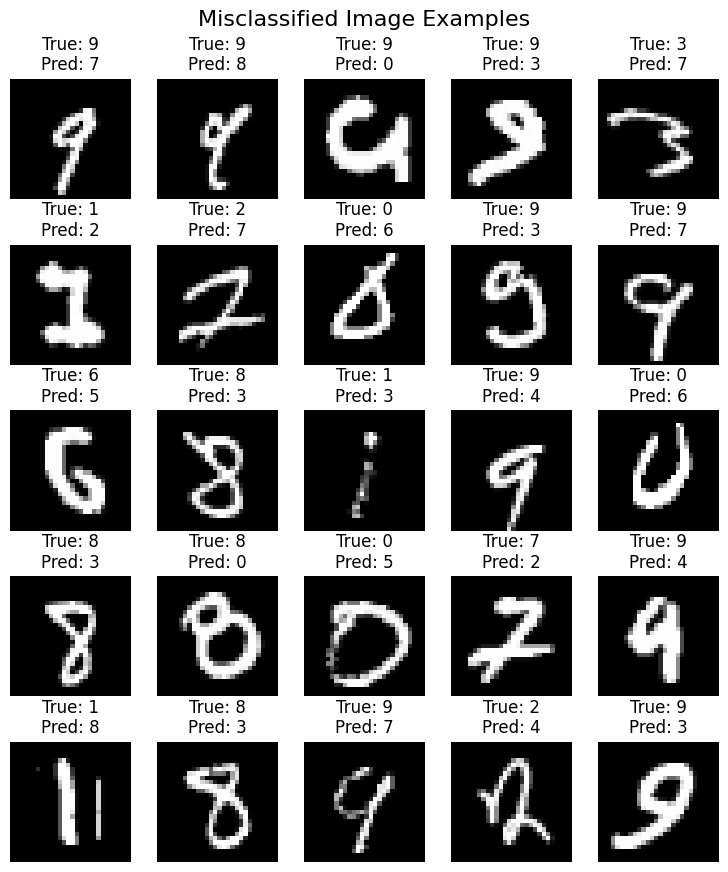


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 56.738567
Test Accuracy: 0.9806
Found 194 misclassified images.


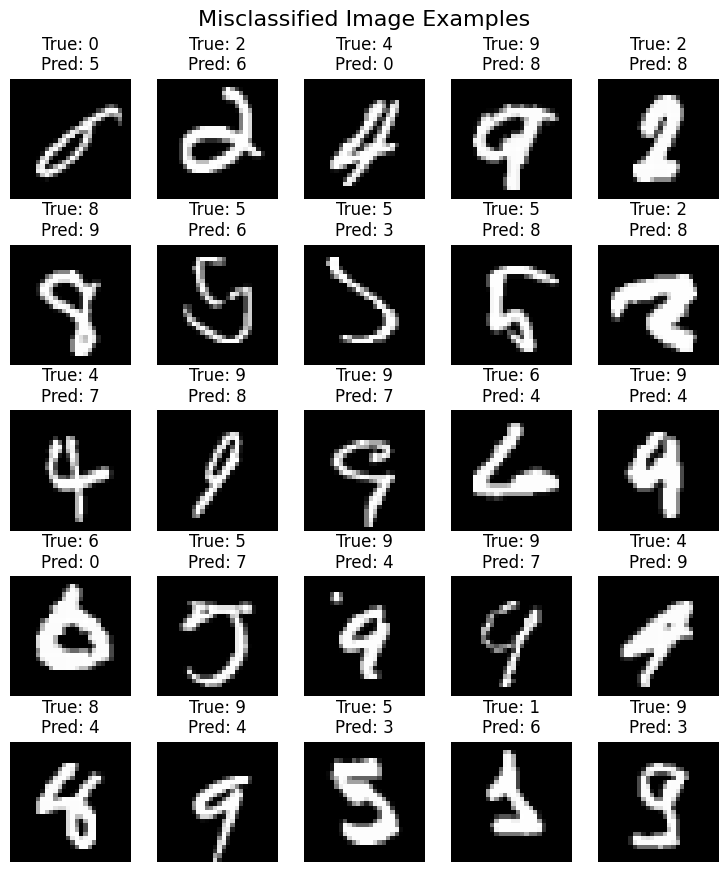


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 56.203315
Test Accuracy: 0.9809
Found 191 misclassified images.


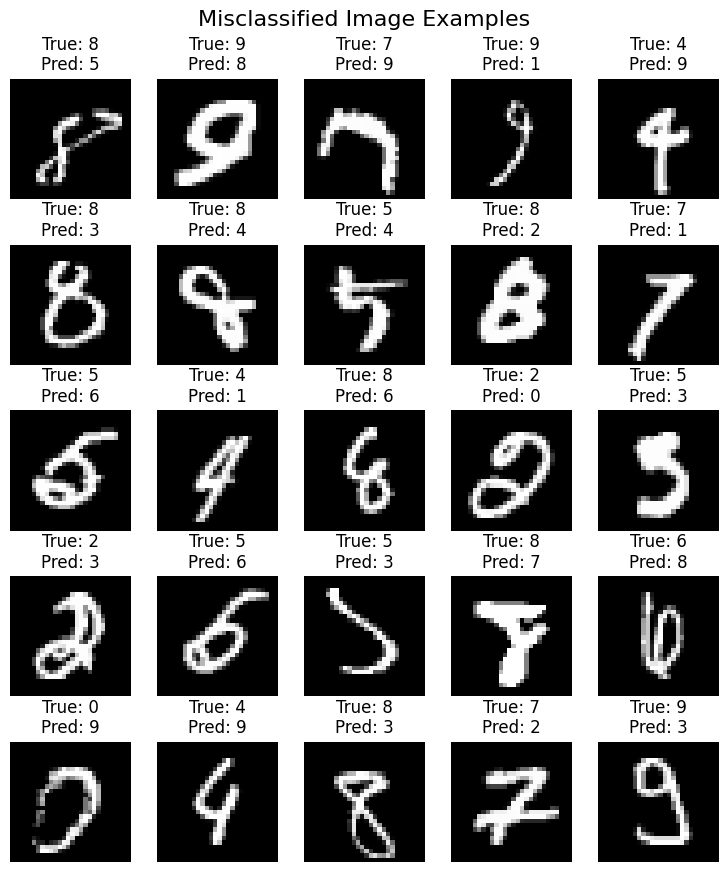


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 56.740473
Test Accuracy: 0.9822
Found 178 misclassified images.


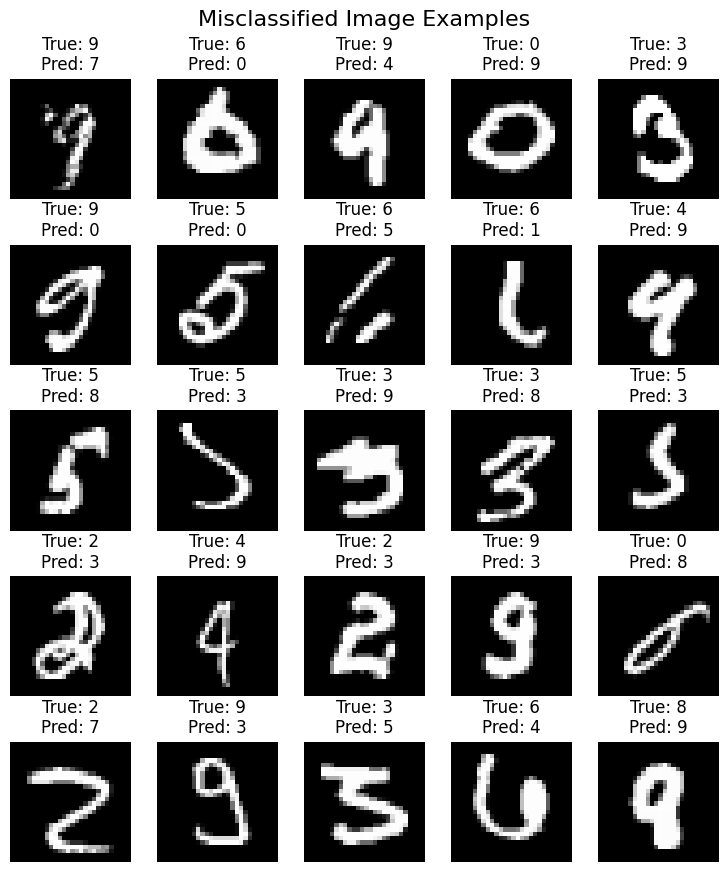


Evaluating on the test set for {'layer_dimensions': [784, 1024, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 54.830755
Test Accuracy: 0.9810
Found 190 misclassified images.


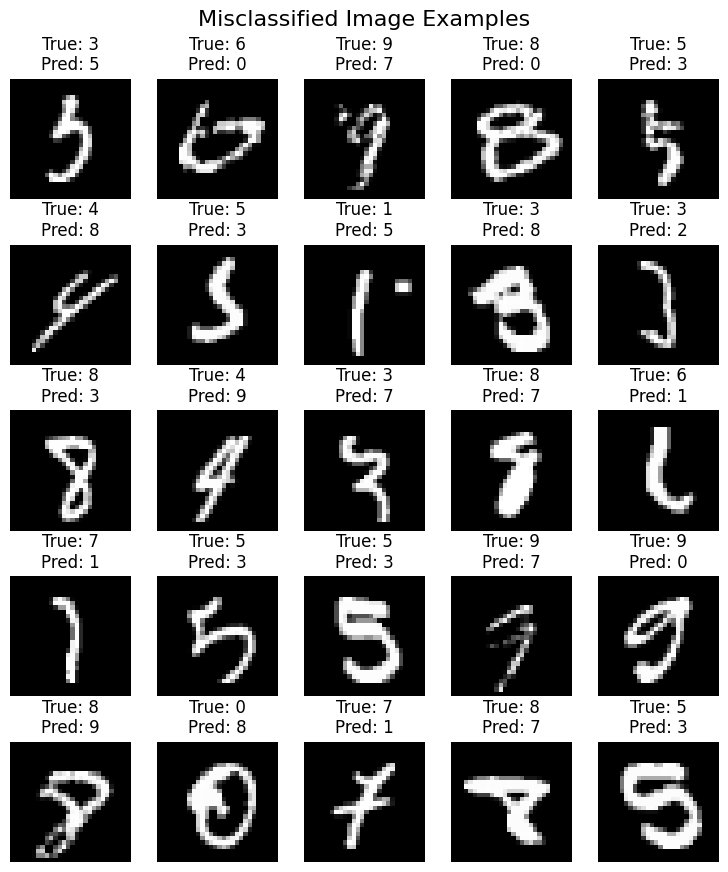

In [12]:
# Evaluate on the test set
for (mlp_configuration, trained_configurable_model, _, total_duration) in configurable_mlp_results:
    print(f"\nEvaluating on the test set for {mlp_configuration} which took {total_duration}")
    A2_test, _ = trained_configurable_model.forward_pass(X_test)
    predictions_test = get_predictions(A2_test)
    test_accuracy = get_accuracy(predictions_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plot_misclassified_images(X_test_orig=X_test_orig, y_test_orig=y_test_orig, y_pred=predictions_test)

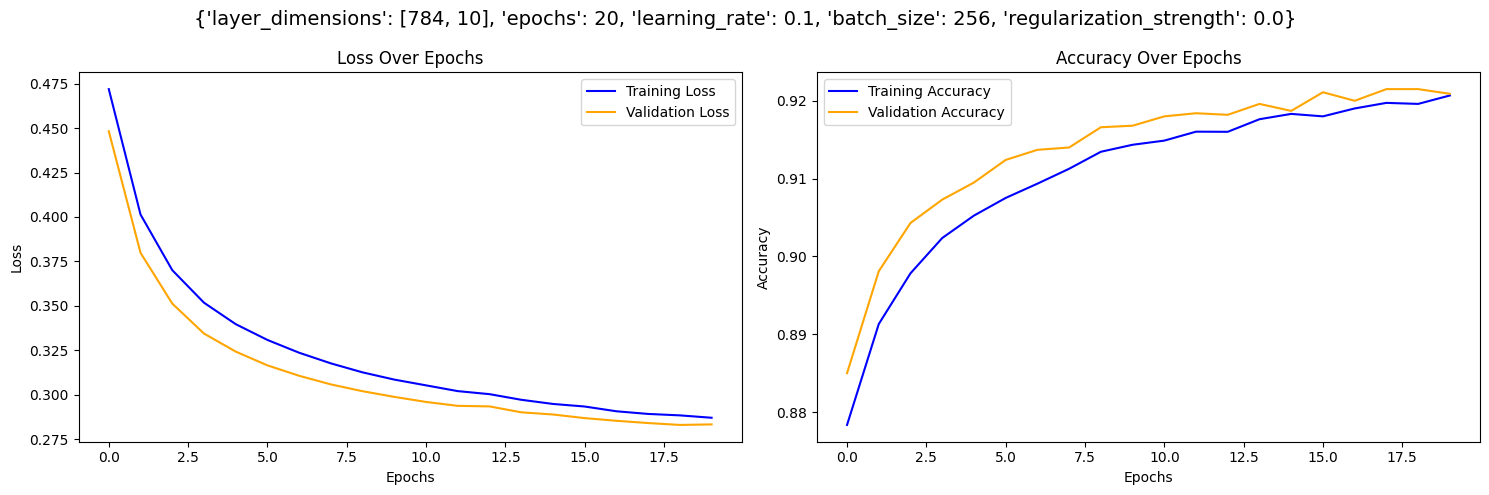

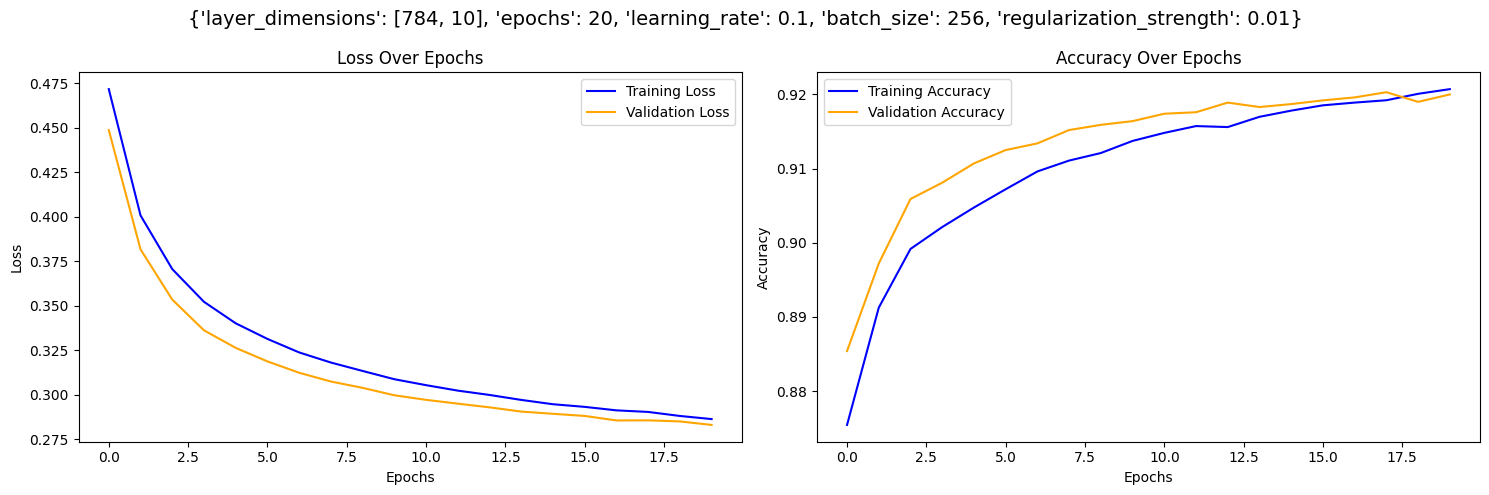

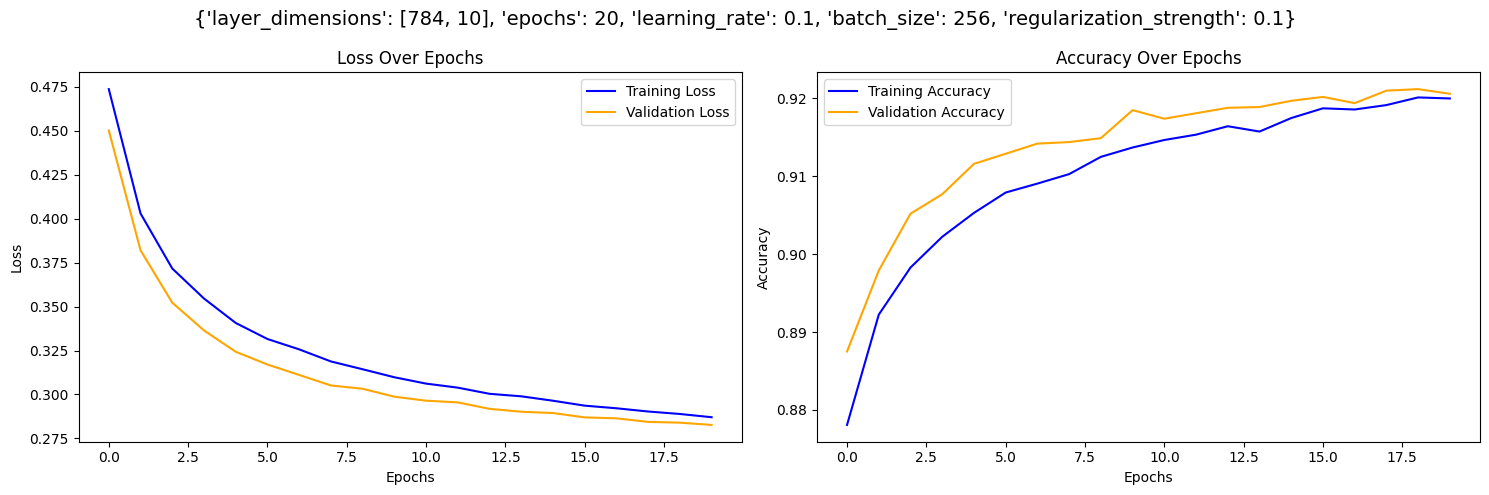

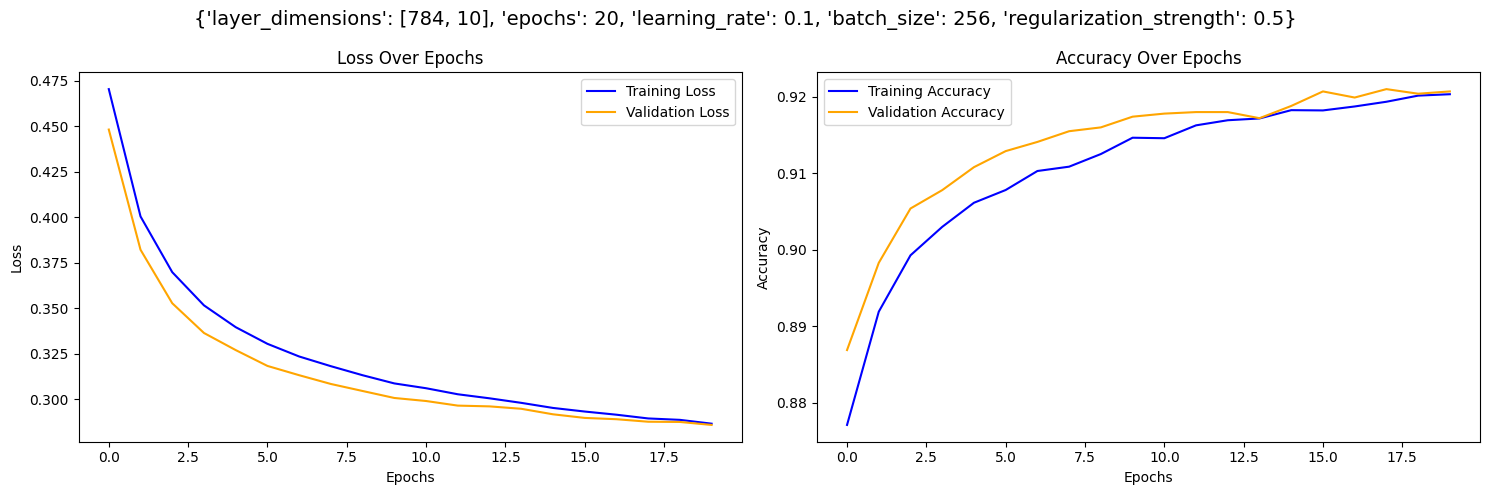

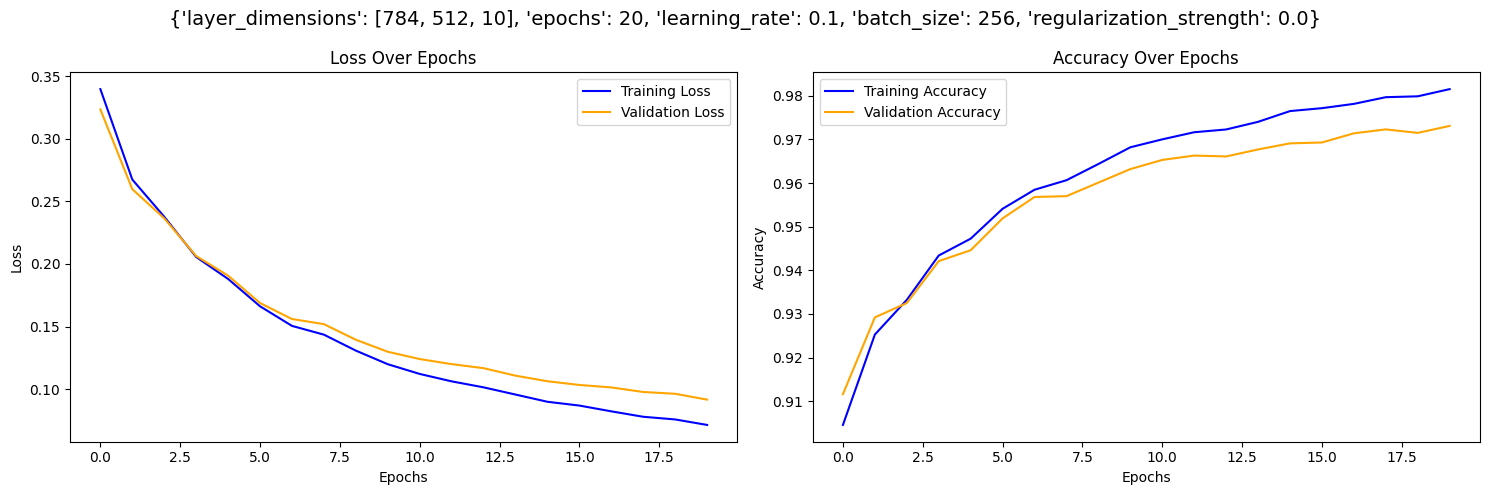

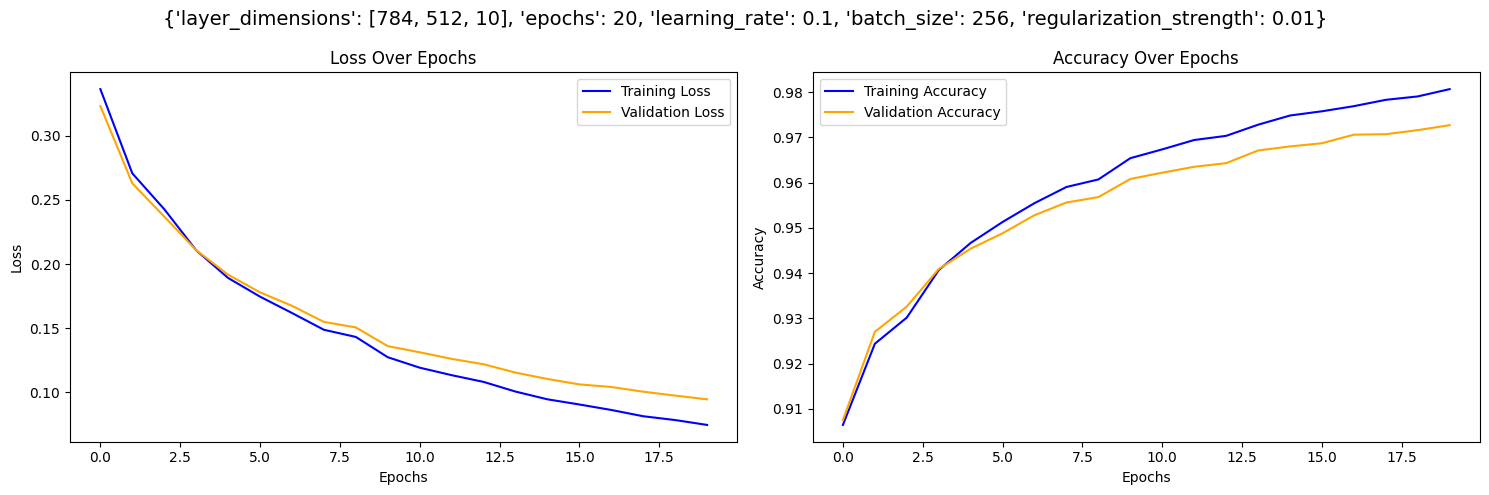

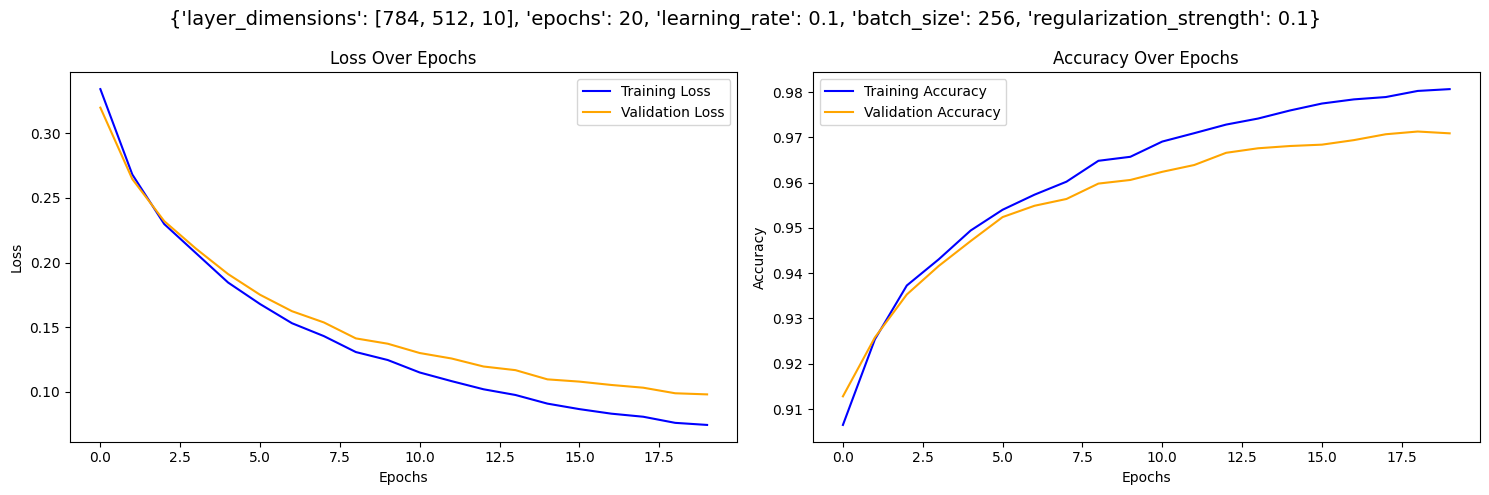

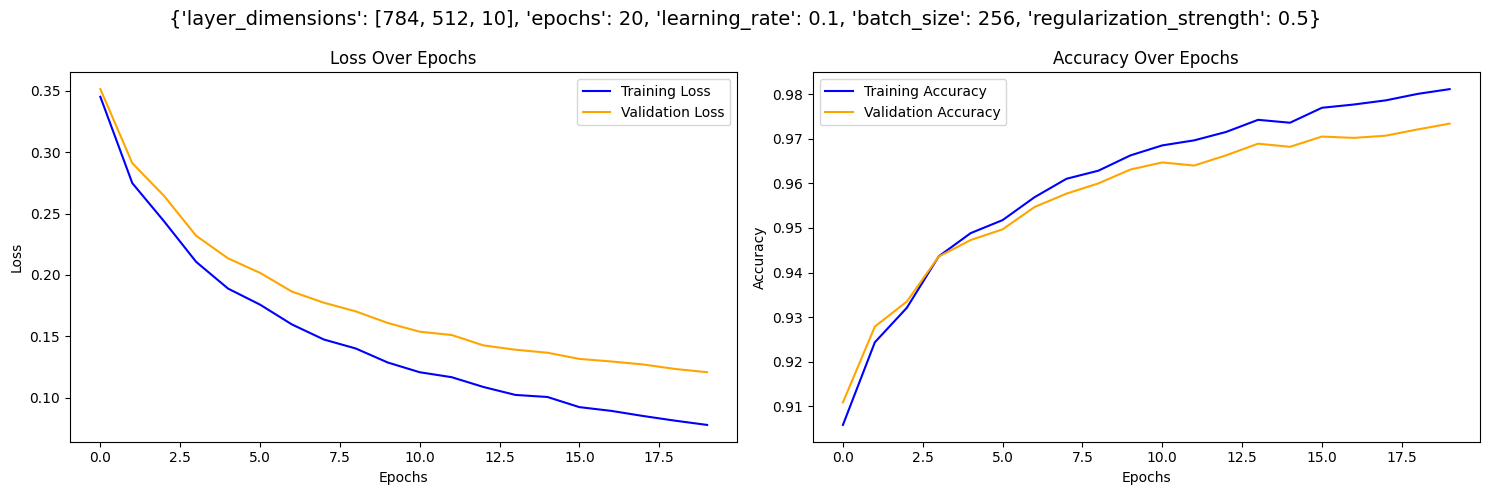

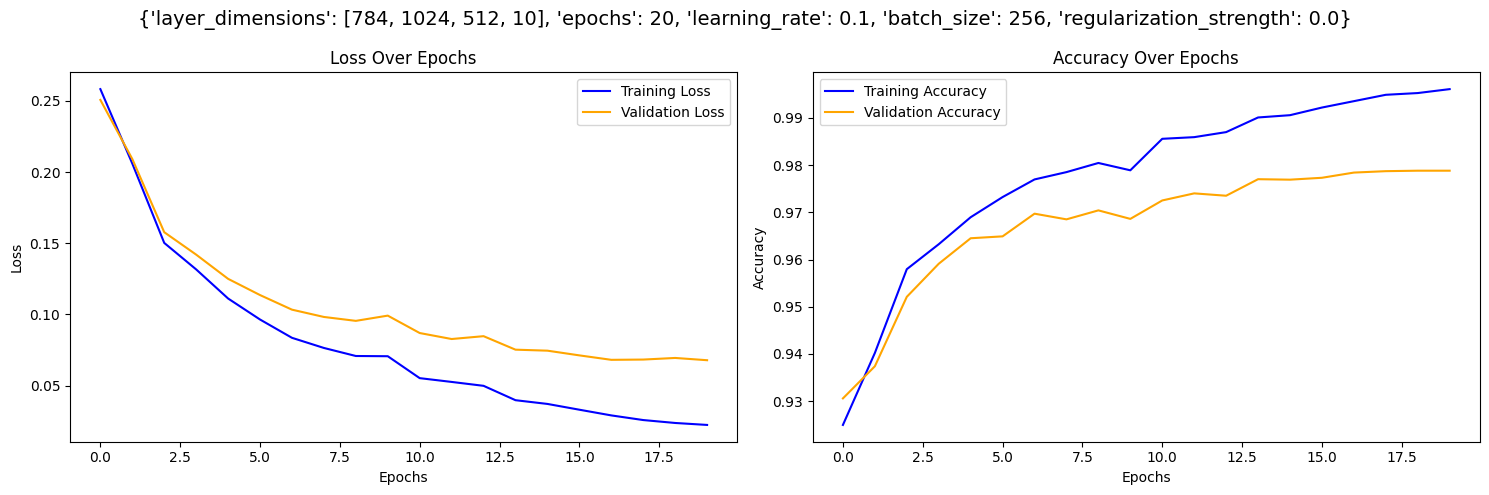

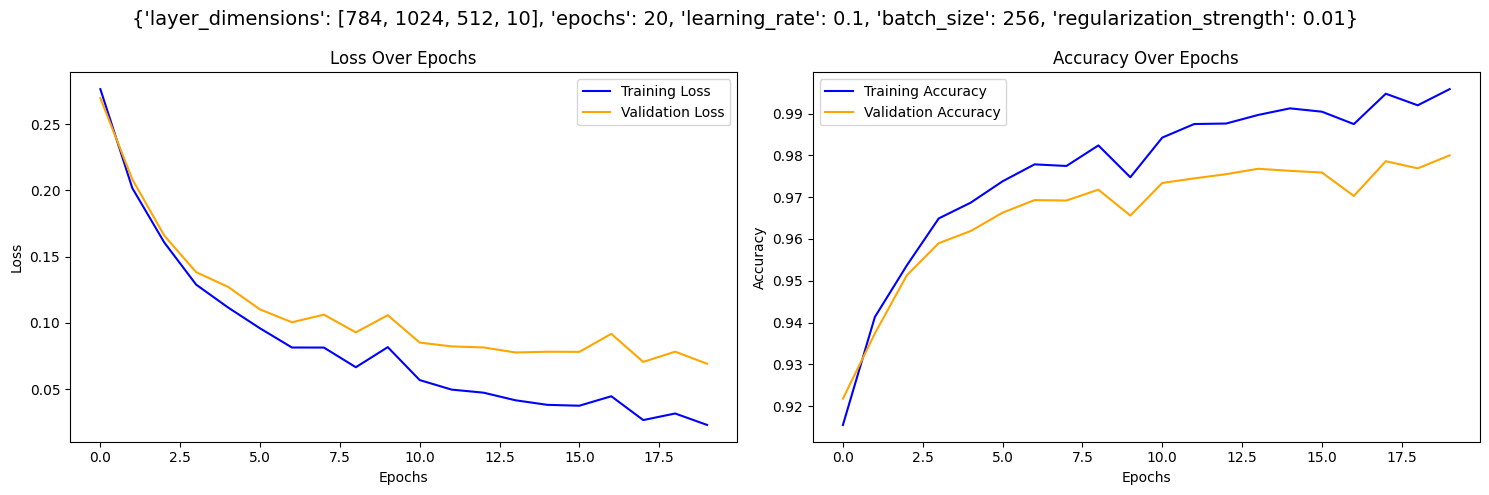

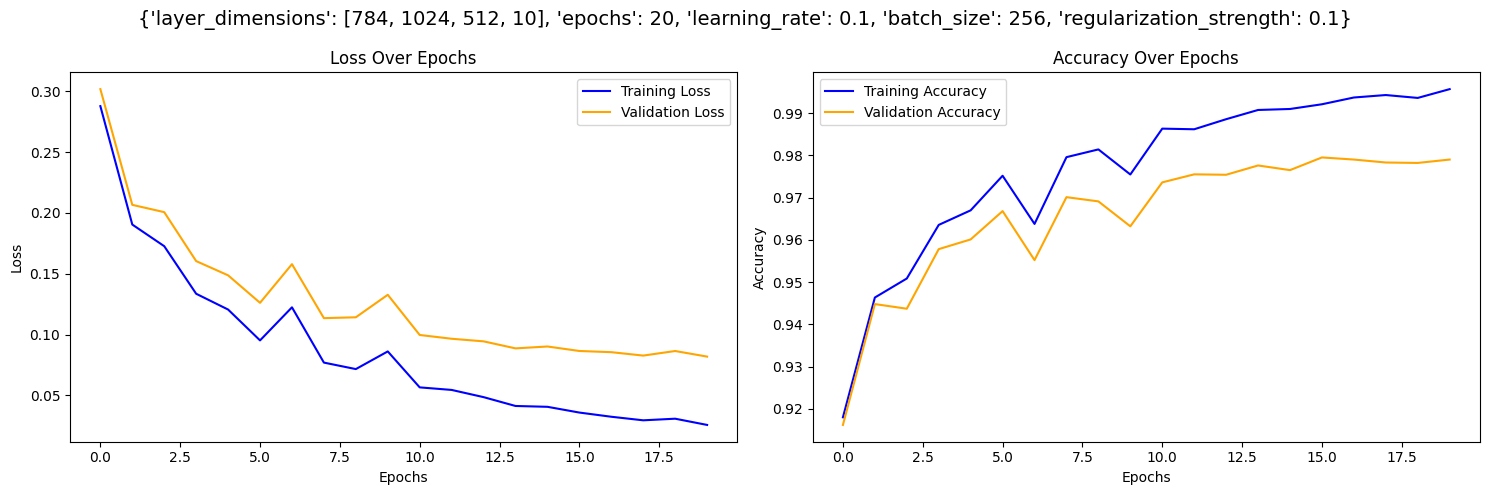

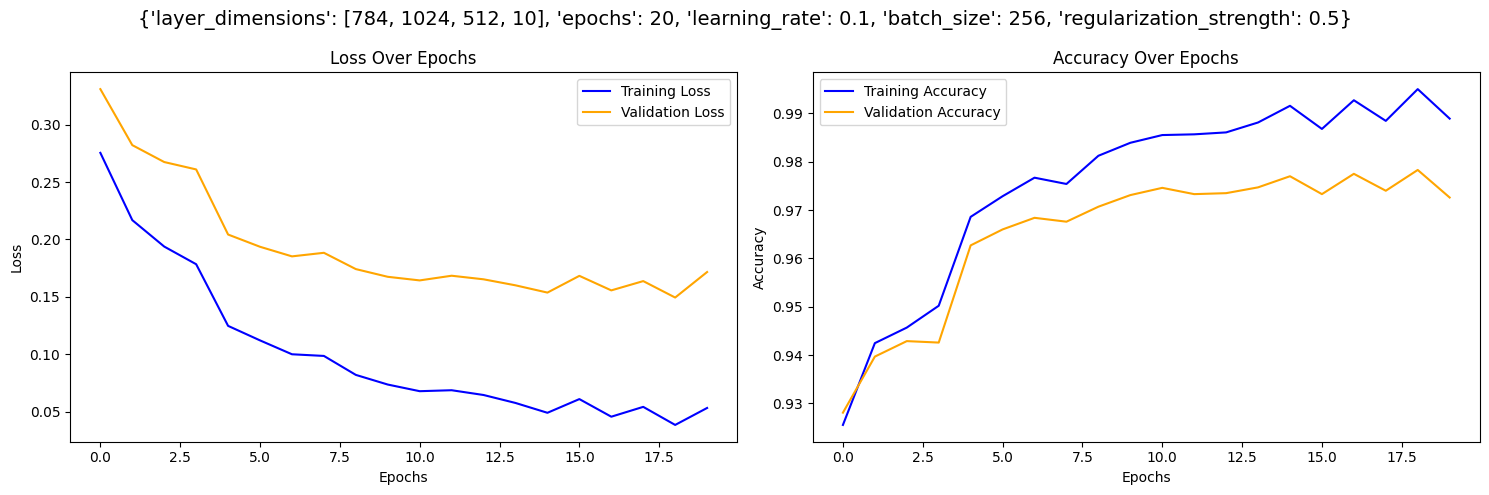

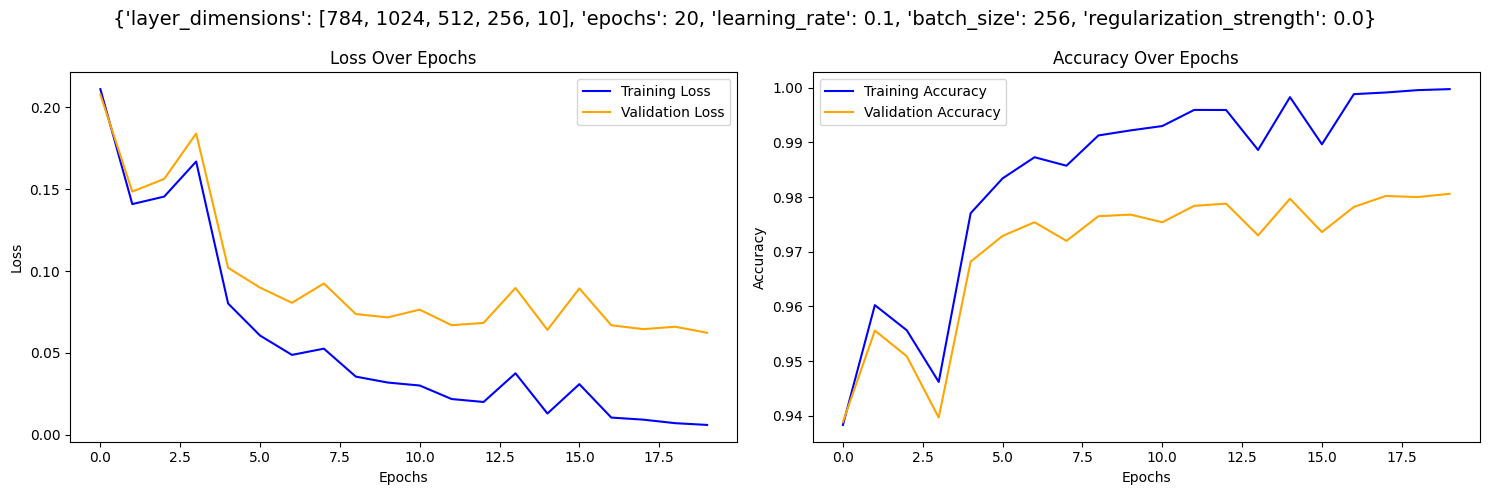

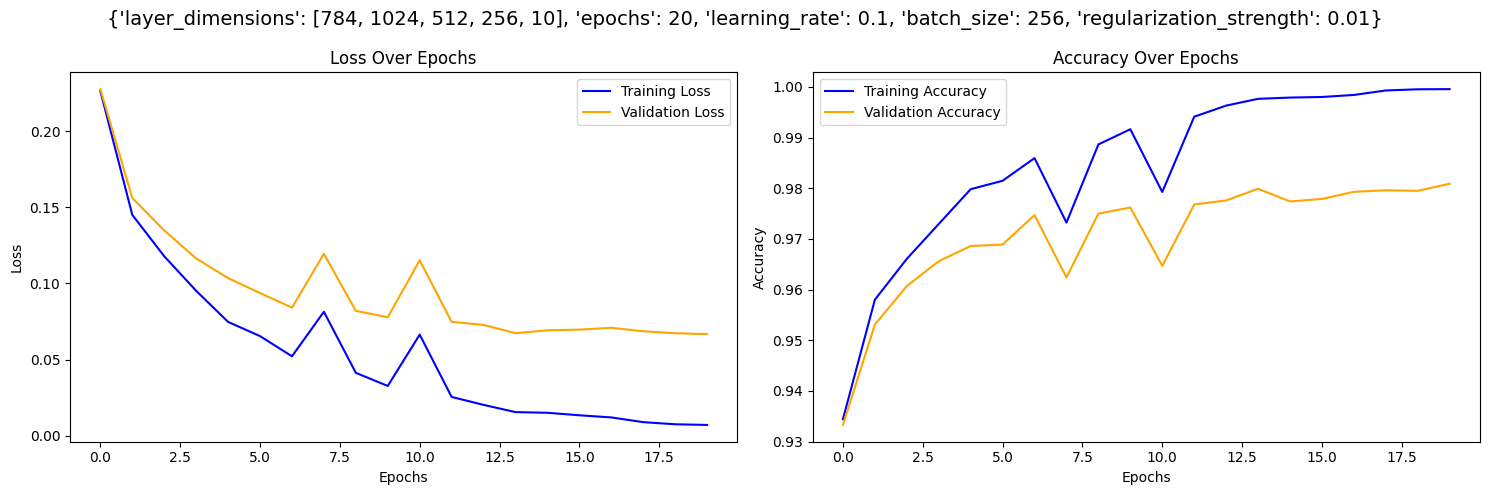

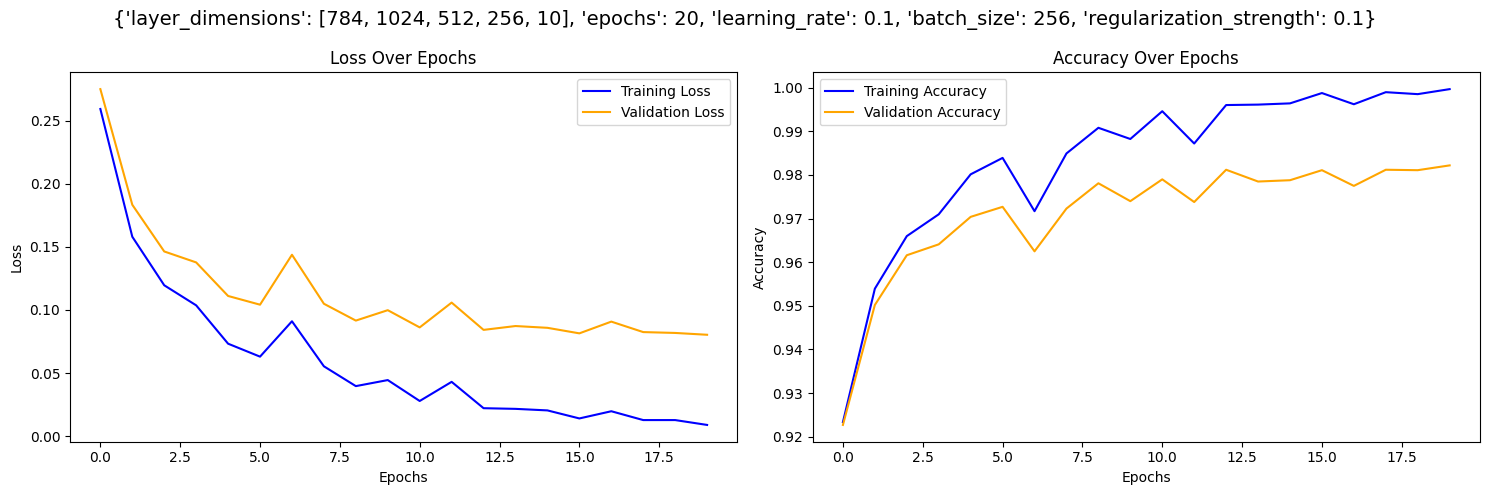

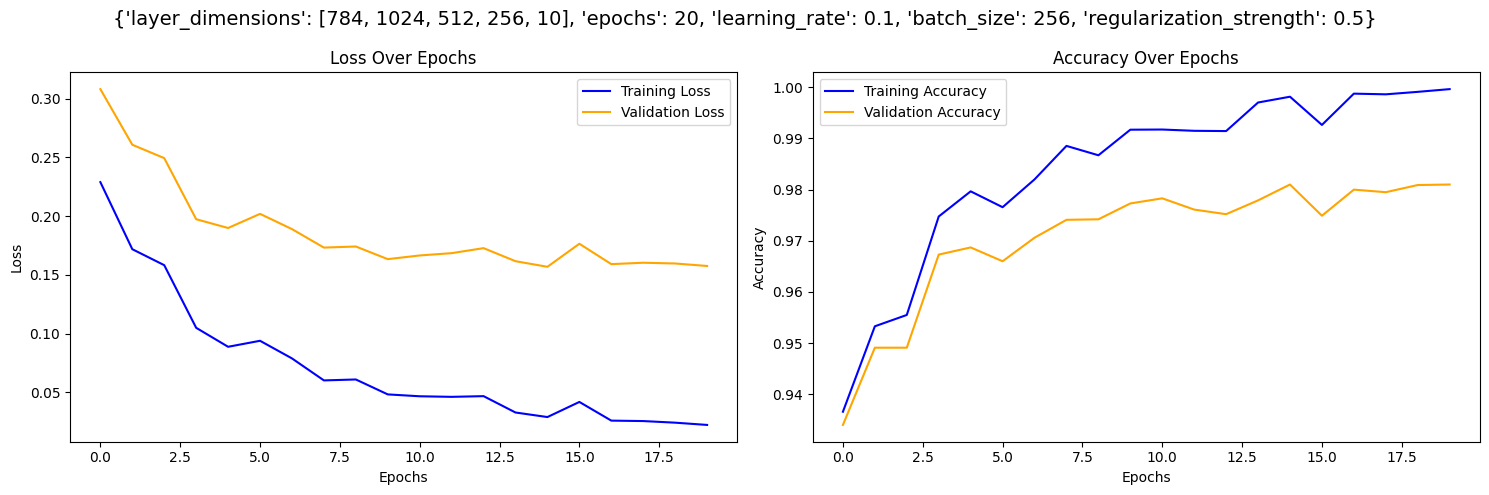

In [14]:
for (mlp_configuration, trained_configurable_model, training_history, total_duration) in configurable_mlp_results:
    plot_training_history(training_history, str(mlp_configuration))